In [ ]:
from tensorflow import keras
import pandas as pd
import numpy as np

import shap

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score, RandomizedSearchCV
from tensorflow.keras import layers,models, optimizers, callbacks, regularizers

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from sklearn.neural_network import MLPRegressor




In [7]:
df = pd.read_csv("../data_prepared.csv")


### craindo novas features

# 1. Bugs e retrabalho estimados
df["qtd_bugs"] = df["percentual_bugs"] * df["cartoes_previstos"]

df["qtd_retrabalho"] = df["percentual_retrabalho"] * df["cartoes_previstos"]

# 2. Carga por membro
df["carga_cartoes_por_membro"] = df["cartoes_previstos"] / df["qtd_membros"]
df["carga_storypoints_por_membro"] = df["story_points_previstos"] / df["qtd_membros"]

# 3. Eficiência (velocidade normalizada)
df["eficiencia"] = df["velocidade_passada"] / df["cartoes_previstos"]

# 4. Complexidade total
df["complexidade_total"] = df["complexidade_media"] * df["cartoes_previstos"]

# 5. Produtividade gap
df["produtividade_gap"] = (df["velocidade_passada"] / df["qtd_membros"]) - df["produtividade_estimada"]



X = df.drop(columns=["duracao_dias"])
y = df["duracao_dias"]

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [17]:
df

,qtd_membros,duracao_dias,cartoes_previstos,story_points_previstos,tipo_dominio,complexidade_media,percentual_bugs,percentual_retrabalho,velocidade_passada,produtividade_estimada,qtd_bugs,qtd_retrabalho,carga_cartoes_por_membro,carga_storypoints_por_membro,eficiencia,complexidade_total,produtividade_gap
0,5,20,23,1.603110,1,2.5,0.20,0.05,32.57,2.202321,4.60,1.15,4.600000,0.320622,1.416087,57.5,4.311679
1,6,14,49,-0.650644,1,2.4,0.05,0.13,45.12,-1.258732,2.45,6.37,8.166667,-0.108441,0.920816,117.6,8.778732
2,7,20,49,0.437375,1,2.9,0.12,0.18,69.79,-0.460027,5.88,8.82,7.000000,0.062482,1.424286,142.1,10.430027
3,6,13,31,-0.161035,0,3.7,0.10,0.10,47.70,-0.699639,3.10,3.10,5.166667,-0.026839,1.538710,114.7,8.649639
4,5,15,48,-0.242637,1,2.1,0.17,0.12,42.69,-0.326910,8.16,5.76,9.600000,-0.048527,0.889375,100.8,8.864910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4,17,27,0.095426,1,1.7,0.09,0.09,41.29,0.951017,2.43,2.43,6.750000,0.023857,1.529259,45.9,9.371483
4996,5,16,34,-0.106634,1,2.2,0.22,0.16,33.49,-0.140545,7.48,5.44,6.800000,-0.021327,0.985000,74.8,6.838545
4997,6,21,43,2.613413,0,2.5,0.22,0.14,68.78,2.468556,9.46,6.02,7.166667,0.435569,1.599535,107.5,8.994777
4998,5,14,45,-0.650644,1,2.1,0.17,0.17,43.01,-0.886003,7.65,7.65,9.000000,-0.130129,0.955778,94.5,9.488003


In [20]:
df.describe()

,qtd_membros,duracao_dias,cartoes_previstos,story_points_previstos,tipo_dominio,complexidade_media,percentual_bugs,percentual_retrabalho,velocidade_passada,produtividade_estimada,qtd_bugs,qtd_retrabalho,carga_cartoes_por_membro,carga_storypoints_por_membro,eficiencia,complexidade_total,produtividade_gap
count,5000.000000,5000.000000,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,5.007800,15.555800,34.990200,1.620037e-16,1.485000,3.005680,0.159570,0.134250,49.840362,7.567280e-17,5.598472,4.697294,7.637276,-0.042825,1.530267,105.232980,10.890605
std,1.420332,3.447617,8.920427,1.000100e+00,1.122153,0.863672,0.060599,0.046622,11.518774,1.000100e+00,2.647051,2.071626,3.118025,0.213451,0.564752,41.381803,4.444157
min,3.000000,10.000000,20.000000,-1.699805e+00,0.000000,1.500000,0.030000,0.030000,30.010000,-1.791201e+00,0.660000,0.800000,2.857143,-0.566602,0.611200,30.000000,2.089107
25%,4.000000,13.000000,27.000000,-7.439026e-01,0.000000,2.300000,0.110000,0.100000,39.760000,-7.262620e-01,3.510000,3.080000,5.285714,-0.185976,1.117610,73.100000,7.657406
50%,5.000000,16.000000,35.000000,-1.843500e-01,1.000000,3.000000,0.160000,0.130000,49.520000,-1.405454e-01,5.250000,4.400000,7.000000,-0.030725,1.423751,98.600000,10.024433
75%,6.000000,19.000000,43.000000,5.733774e-01,2.000000,3.700000,0.210000,0.170000,59.797500,7.114061e-01,7.360000,6.090000,9.400000,0.101340,1.847330,133.000000,13.368351
max,7.000000,21.000000,50.000000,3.429427e+00,3.000000,4.500000,0.290000,0.240000,69.990000,2.468556e+00,14.210000,11.520000,16.666667,0.489918,3.495500,225.000000,24.687868


##### Para a ANN resolvi fazer um Scaler que englobasse todas as colunas, a fim de obter um desempeho melhor ao longo das épocas

In [22]:

num_cols = [
    "complexidade_total",
    "cartoes_previstos",
    "velocidade_passada",
    "qtd_membros",
    "story_points_previstos",
    "carga_storypoints_por_membro",
    "percentual_bugs",
    "percentual_retrabalho",
    "produtividade_estimada"
]


cat_cols = ["tipo_dominio"]


preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),      # escalona numéricas
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)  # one-hot em categóricas
    ]
)

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

print("Shape após transformação:")
print("X_train:", X_train_scaled.shape)
print("X_test:", X_test_scaled.shape)


Shape após transformação:
X_train: (4000, 13)
X_test: (1000, 13)


In [29]:
X_train.values

array([[  6.        ,  32.        ,   0.7482376 , ...,   1.089375  ,
         76.8       ,   5.47132267],
       [  3.        ,  34.        ,  -1.51328742, ...,   1.53029412,
         71.4       ,  18.70855894],
       [  5.        ,  38.        ,  -0.51464149, ...,   0.95210526,
        125.4       ,   7.93563852],
       ...,
       [  5.        ,  29.        ,  -0.37863913, ...,   2.07241379,
         46.4       ,  12.53327414],
       [  6.        ,  24.        ,  -0.41749695, ...,   2.09      ,
        105.6       ,   9.35249684],
       [  5.        ,  37.        ,   0.82595324, ...,   1.33108108,
         74.        ,   8.71261816]], shape=(4000, 16))

#### TEstei inicialmente esse primeiro modelo autoral, com 4 camadas densas, regularização, Batch norm e diferentes funções de ativação pra capturar a não linearidade dos dados. Porém o modelo teve um desempenho bem inferior em comparação com o RF, onde obtvemos uma *MAE = 1.98 | RMSE = 2.4 e R^2 = 0.48*

In [42]:
model = models.Sequential([
    layers.Dense(256, input_shape=(X_train_scaled.shape[1],), activation='swish'),
    layers.Dropout(0.3),

    layers.Dense(128, activation='swish', kernel_regularizer=regularizers.l2(0.0005)),
    layers.Dropout(0.2),

    layers.Dense(64, activation='swish'),
    layers.Dense(32, activation='swish'),

    layers.Dense(1, activation='linear')  # saída para regressão
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error',
    metrics=['mae', 'mse']
)

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Previsão
y_pred = model.predict(X_test_scaled).flatten()

# Métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

Epoch 1/200


c:\Users\Administrador\Downloads\agile_estimator_ofc\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 6.5297 - mae: 6.4367 - mse: 75.5954 - val_loss: 2.2669 - val_mae: 2.1695 - val_mse: 7.2531 - learning_rate: 0.0010
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4232 - mae: 2.3265 - mse: 8.1625 - val_loss: 2.1124 - val_mae: 2.0167 - val_mse: 6.4049 - learning_rate: 0.0010
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3083 - mae: 2.2140 - mse: 7.4168 - val_loss: 2.1565 - val_mae: 2.0640 - val_mse: 6.8160 - learning_rate: 0.0010
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2547 - mae: 2.1639 - mse: 7.1059 - val_loss: 2.1475 - val_mae: 2.0586 - val_mse: 6.9506 - learning_rate: 0.0010
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2546 - mae: 2.1674 - mse: 7.1041 - val_loss: 2.0994 - val_mae: 2.0140 - val_mse: 6.3145 - learning_rate: 0.0010
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2395 - mae: 2.1562 - mse: 7.0147 - val_loss: 2.2039 - val_mae: 2.1226 - v

#### Olhando para o desempenho do modelo durante as épocas é possivel notar que a perda durante a validação é majoritariamente menor que a perda do treino, o que indica que nosso modelo não apresenta Overfitting, mas que também não está generalizando bem o problema apresentado.

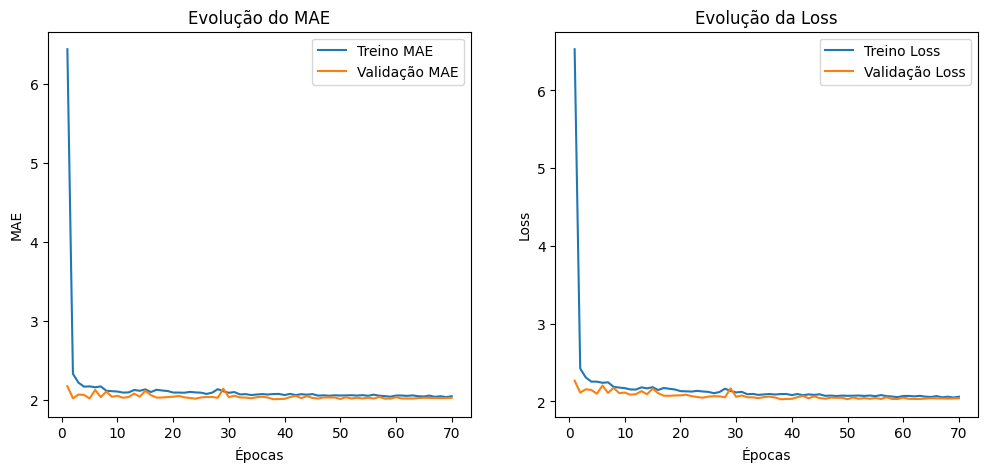

In [44]:

# Recupera os valores do histórico
mae_train = history.history['mae']
mae_val = history.history.get('val_mae')  # pode ser None se não usou validation_split

loss_train = history.history['loss']
loss_val = history.history.get('val_loss')  # idem

epochs = range(1, len(mae_train) + 1)

# Plotando MAE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, mae_train, label='Treino MAE')
if mae_val:
    plt.plot(epochs, mae_val, label='Validação MAE')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.title('Evolução do MAE')
plt.legend()

# Plotando Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss_train, label='Treino Loss')
if loss_val:
    plt.plot(epochs, loss_val, label='Validação Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Evolução da Loss')
plt.legend()

plt.show()


#### Em seguida utilizamos o MLPRegressor(), que é basicamente um modelo de regressão customizavel, a ideia foi definir uma serie de parametros pra esse modlo e testar 'n' combinações a fim de encontrar um ótimo global. Como resultado, obtivemos : 

In [52]:
mlp = MLPRegressor(random_state=42, early_stopping=True, validation_fraction=0.2)

# --- Espaço de busca ---
param_dist = {
    "hidden_layer_sizes": [(128,64,32), (256,128,64,32), (512,256,128)],
    "activation": ["relu", "tanh", "identity", "logistic"],  
    "solver": ["adam", "sgd"],
    "alpha": [0.0001, 0.0005, 0.001, 0.002],
    "learning_rate_init": [0.001, 0.0005, 0.0001],
    "batch_size": [16, 32, 64],
    "max_iter": [500, 1000]
}

# --- Randomized Search ---
search = RandomizedSearchCV(
    estimator=mlp,
    param_distributions=param_dist,
    n_iter=15,             # 30 combinações aleatórias
    scoring='r2',          # métrica para otimização
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# --- Treino ---
search.fit(X_train_scaled, y_train)

# --- Melhor modelo ---
best_mlp = search.best_estimator_

# --- Previsões ---
y_pred = best_mlp.predict(X_test_scaled)

# --- Métricas ---
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Melhor modelo:", search.best_params_)
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Melhor modelo: {'solver': 'adam', 'max_iter': 1000, 'learning_rate_init': 0.0001, 'hidden_layer_sizes': (512, 256, 128), 'batch_size': 16, 'alpha': 0.0001, 'activation': 'tanh'}
MAE: 1.9928, RMSE: 2.4422, R²: 0.4928


#### Validando com Shap

In [55]:
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)

PermutationExplainer explainer: 1001it [02:03,  8.09it/s]                          


C:\Users\Administrador\AppData\Local\Temp\ipykernel_356\677981354.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values,X_test_scaled,feature_names=X_test.columns)


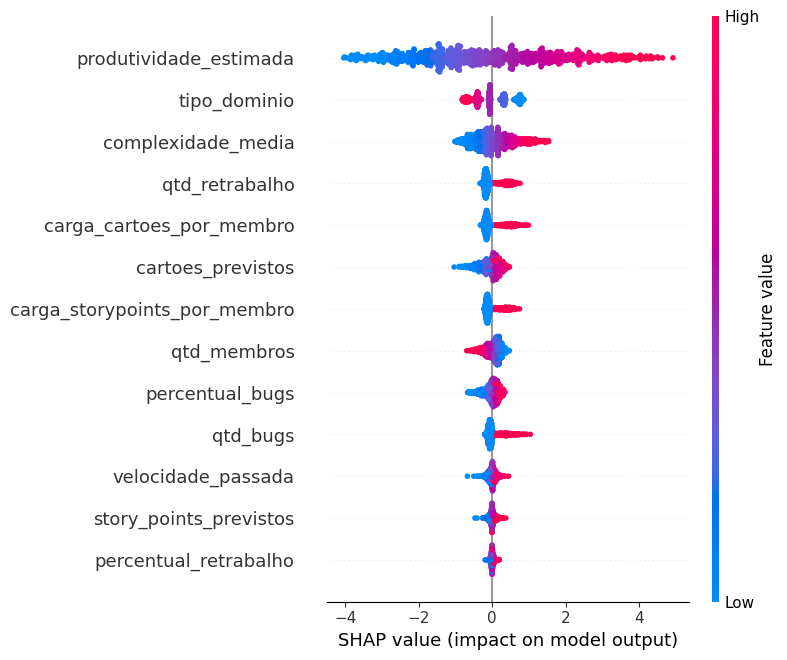

In [59]:
shap.summary_plot(shap_values,X_test_scaled,feature_names=X_test.columns)

In [ ]:
shap.initjs()
shap.force_plot(explainer, shap_values[0,:]  ,X_test_scaled[0,:],feature_names=X_test.columns)

In [66]:
num_features = num_cols
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
all_features = np.concatenate([num_features, cat_features])


In [67]:
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=all_features)

PermutationExplainer explainer: 1001it [11:54,  1.38it/s]                          


C:\Users\Administrador\AppData\Local\Temp\ipykernel_356\4080304710.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


Force plot para amostra 0
Force plot para amostra 1
Force plot para amostra 2
Force plot para amostra 3
Force plot para amostra 4
Force plot para amostra 5
Force plot para amostra 6
Force plot para amostra 7
Force plot para amostra 8
Force plot para amostra 9


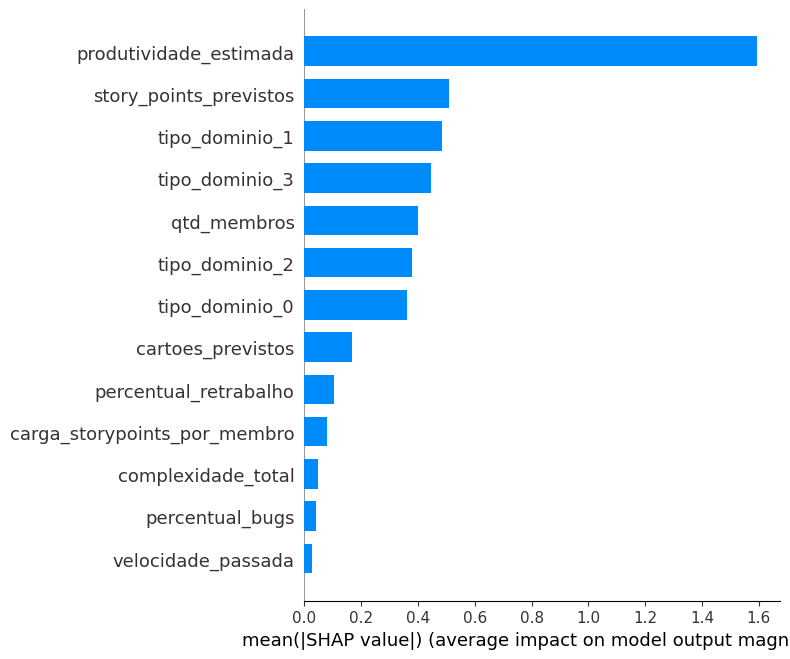

In [69]:

# --- Inicializa o PermutationExplainer ---
explainer = shap.PermutationExplainer(best_mlp.predict, X_train_scaled)

# --- Calcula valores SHAP para o conjunto de teste ---
shap_values = explainer(X_test_scaled)

shap.initjs()
for i in range(min(10, X_test_scaled_df.shape[0])):
    print(f"Force plot para amostra {i}")
    shap.force_plot(
        shap_values.base_values[i],
        shap_values.values[i],
        X_test_scaled_df.iloc[i, :],
        feature_names=all_features  # <- usar all_features
    )

# --- Summary plot global ---
shap.summary_plot(
    shap_values.values,
    X_test_scaled_df,
    feature_names=all_features,  # <- usar all_features
    plot_type="bar"
)

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  13%|█▎        | 13/100 [00:00<?, ?it/s]

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


PermutationExplainer explainer:  15%|█▌        | 15/100 [00:11<00:47,  1.77it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  16%|█▌        | 16/100 [00:12<01:13,  1.15it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


PermutationExplainer explainer:  17%|█▋        | 17/100 [00:14<01:40,  1.21s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  18%|█▊        | 18/100 [00:15<01:33,  1.14s/it]

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  19%|█▉        | 19/100 [00:16<01:27,  1.08s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  20%|██        | 20/100 [00:17<01:26,  1.08s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  21%|██        | 21/100 [00:18<01:21,  1.03s/it]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  22%|██▏       | 22/100 [00:19<01:13,  1.06it/s]

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  23%|██▎       | 23/100 [00:20<01:14,  1.04it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


PermutationExplainer explainer:  24%|██▍       | 24/100 [00:21<01:13,  1.03it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


PermutationExplainer explainer:  25%|██▌       | 25/100 [00:22<01:16,  1.02s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  26%|██▌       | 26/100 [00:23<01:14,  1.00s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


PermutationExplainer explainer:  27%|██▋       | 27/100 [00:24<01:13,  1.01s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


PermutationExplainer explainer:  28%|██▊       | 28/100 [00:25<01:11,  1.01it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


PermutationExplainer explainer:  29%|██▉       | 29/100 [00:26<01:13,  1.03s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  30%|███       | 30/100 [00:27<01:07,  1.04it/s]

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


PermutationExplainer explainer:  31%|███       | 31/100 [00:28<01:07,  1.02it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


PermutationExplainer explainer:  32%|███▏      | 32/100 [00:29<01:23,  1.23s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


PermutationExplainer explainer:  33%|███▎      | 33/100 [00:31<01:23,  1.24s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  34%|███▍      | 34/100 [00:31<01:10,  1.07s/it]

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


PermutationExplainer explainer:  35%|███▌      | 35/100 [00:32<01:07,  1.03s/it]

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


PermutationExplainer explainer:  36%|███▌      | 36/100 [00:35<01:34,  1.48s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


PermutationExplainer explainer:  37%|███▋      | 37/100 [00:37<01:50,  1.75s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


PermutationExplainer explainer:  38%|███▊      | 38/100 [00:39<01:51,  1.80s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  39%|███▉      | 39/100 [00:40<01:31,  1.51s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


PermutationExplainer explainer:  40%|████      | 40/100 [00:41<01:27,  1.46s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


PermutationExplainer explainer:  41%|████      | 41/100 [00:43<01:34,  1.60s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


PermutationExplainer explainer:  42%|████▏     | 42/100 [00:46<01:51,  1.92s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


PermutationExplainer explainer:  43%|████▎     | 43/100 [00:50<02:22,  2.49s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


PermutationExplainer explainer:  44%|████▍     | 44/100 [00:52<02:10,  2.34s/it]

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


PermutationExplainer explainer:  45%|████▌     | 45/100 [00:53<01:49,  2.00s/it]

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


PermutationExplainer explainer:  46%|████▌     | 46/100 [00:55<01:43,  1.93s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  47%|████▋     | 47/100 [00:56<01:27,  1.66s/it]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


PermutationExplainer explainer:  48%|████▊     | 48/100 [00:57<01:17,  1.48s/it]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


PermutationExplainer explainer:  49%|████▉     | 49/100 [00:58<01:12,  1.42s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  50%|█████     | 50/100 [00:59<01:07,  1.35s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


PermutationExplainer explainer:  51%|█████     | 51/100 [01:00<01:05,  1.33s/it]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


PermutationExplainer explainer:  52%|█████▏    | 52/100 [01:02<01:01,  1.28s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


PermutationExplainer explainer:  53%|█████▎    | 53/100 [01:03<00:57,  1.23s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  54%|█████▍    | 54/100 [01:04<00:59,  1.28s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


PermutationExplainer explainer:  55%|█████▌    | 55/100 [01:05<00:57,  1.28s/it]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  56%|█████▌    | 56/100 [01:06<00:50,  1.14s/it]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  57%|█████▋    | 57/100 [01:07<00:47,  1.11s/it]

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  58%|█████▊    | 58/100 [01:08<00:42,  1.02s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  59%|█████▉    | 59/100 [01:09<00:41,  1.01s/it]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  60%|██████    | 60/100 [01:10<00:37,  1.06it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  61%|██████    | 61/100 [01:16<01:35,  2.45s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


PermutationExplainer explainer:  62%|██████▏   | 62/100 [01:17<01:16,  2.00s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  63%|██████▎   | 63/100 [01:18<01:01,  1.66s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  64%|██████▍   | 64/100 [01:18<00:49,  1.38s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  65%|██████▌   | 65/100 [01:19<00:43,  1.24s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


PermutationExplainer explainer:  66%|██████▌   | 66/100 [01:20<00:39,  1.18s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  67%|██████▋   | 67/100 [01:21<00:34,  1.04s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  68%|██████▊   | 68/100 [01:22<00:31,  1.02it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  69%|██████▉   | 69/100 [01:23<00:28,  1.10it/s]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  70%|███████   | 70/100 [01:23<00:27,  1.10it/s]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  71%|███████   | 71/100 [01:24<00:24,  1.17it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  72%|███████▏  | 72/100 [01:25<00:24,  1.16it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  73%|███████▎  | 73/100 [01:26<00:22,  1.19it/s]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  74%|███████▍  | 74/100 [01:27<00:22,  1.17it/s]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


PermutationExplainer explainer:  75%|███████▌  | 75/100 [01:28<00:21,  1.18it/s]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  76%|███████▌  | 76/100 [01:28<00:20,  1.18it/s]

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  77%|███████▋  | 77/100 [01:29<00:18,  1.25it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


PermutationExplainer explainer:  78%|███████▊  | 78/100 [01:30<00:19,  1.16it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  79%|███████▉  | 79/100 [01:31<00:19,  1.08it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


PermutationExplainer explainer:  80%|████████  | 80/100 [01:33<00:20,  1.04s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  81%|████████  | 81/100 [01:33<00:17,  1.10it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  82%|████████▏ | 82/100 [01:34<00:16,  1.11it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  83%|████████▎ | 83/100 [01:35<00:14,  1.16it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  84%|████████▍ | 84/100 [01:36<00:14,  1.11it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  85%|████████▌ | 85/100 [01:37<00:13,  1.14it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  86%|████████▌ | 86/100 [01:37<00:12,  1.15it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  87%|████████▋ | 87/100 [01:38<00:10,  1.25it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  88%|████████▊ | 88/100 [01:39<00:09,  1.21it/s]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  89%|████████▉ | 89/100 [01:40<00:08,  1.27it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  90%|█████████ | 90/100 [01:41<00:08,  1.16it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  91%|█████████ | 91/100 [01:41<00:07,  1.22it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  92%|█████████▏| 92/100 [01:42<00:06,  1.21it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


PermutationExplainer explainer:  93%|█████████▎| 93/100 [01:43<00:06,  1.11it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  94%|█████████▍| 94/100 [01:44<00:05,  1.05it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  95%|█████████▌| 95/100 [01:45<00:04,  1.13it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  96%|█████████▌| 96/100 [01:46<00:03,  1.13it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  97%|█████████▋| 97/100 [01:47<00:02,  1.15it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  98%|█████████▊| 98/100 [01:48<00:01,  1.10it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  99%|█████████▉| 99/100 [01:49<00:00,  1.18it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer: 100%|██████████| 100/100 [01:50<00:00,  1.12it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer: 101it [01:50,  1.26s/it]                         


Force plot para amostra 0
Force plot para amostra 1
Force plot para amostra 2
Force plot para amostra 3
Force plot para amostra 4
Force plot para amostra 5
Force plot para amostra 6
Force plot para amostra 7
Force plot para amostra 8
Force plot para amostra 9


C:\Users\Administrador\AppData\Local\Temp\ipykernel_356\53247254.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


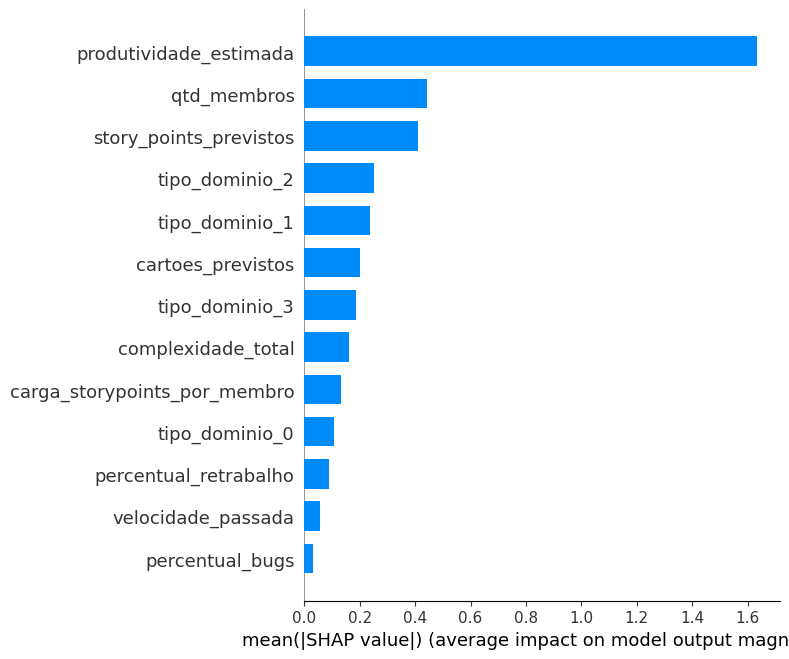

In [ ]:

# --- Inicializa o PermutationExplainer ---
explainer = shap.PermutationExplainer(model.predict, X_train_scaled, max_evals=27)

# --- Calcula valores SHAP para o conjunto de teste ---
shap_values = explainer(X_test_scaled[:100])

shap.initjs()
for i in range(min(10, X_test_scaled_df.shape[0])):
    print(f"Force plot para amostra {i}")
    shap.force_plot(
        shap_values.base_values[i],
        shap_values.values[i],
        X_test_scaled_df.iloc[i, :],
        feature_names=all_features  # <- usar all_features
    )



C:\Users\Administrador\AppData\Local\Temp\ipykernel_356\1817548992.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


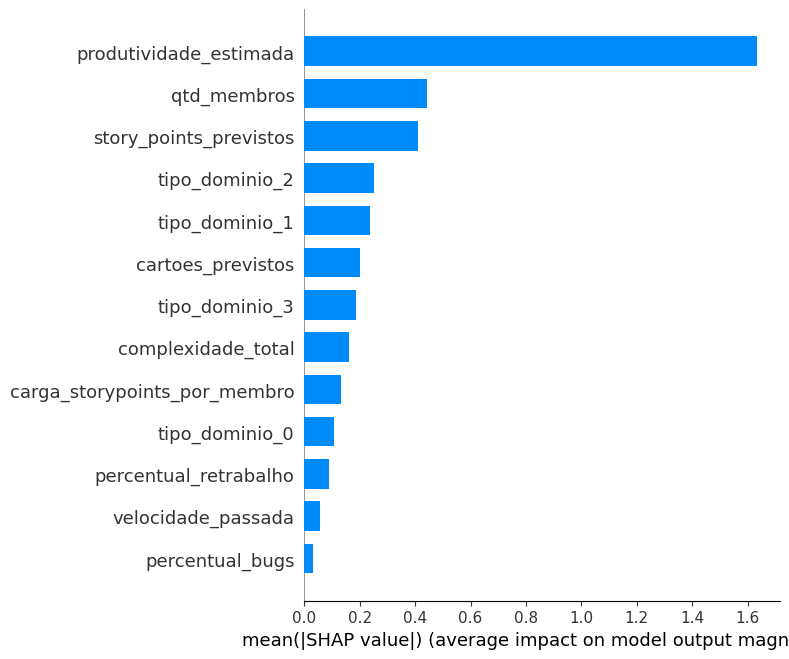

In [74]:
# --- Summary plot global ---
shap.summary_plot(
    shap_values.values,
    X_test_scaled_df,
    feature_names=all_features,  # <- usar all_features
    plot_type="bar"
)